In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from gmdh import Combi, Mia
from gmdhpy.gmdh import MultilayerGMDH, RefFunctionType, CriterionType
from gplearn.genetic import SymbolicRegressor

In [20]:
df = pd.read_csv("Adidas US Sales.csv", sep=';')

In [21]:
df["invoice_date"] = pd.to_datetime(df["invoice_date"], format="%d.%m.%Y")

In [22]:
df_monthly = df.groupby(pd.Grouper(key="invoice_date", freq="M"))["total_sales"].sum().reset_index()

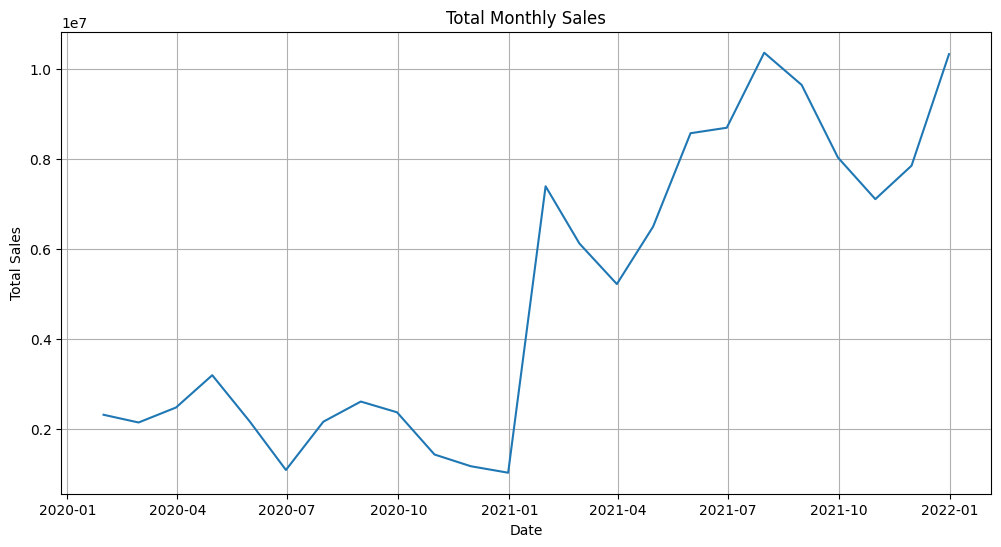

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(df_monthly["invoice_date"], df_monthly["total_sales"])
plt.title("Total Monthly Sales")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

In [24]:
ts = df_monthly["total_sales"].values
dates = df_monthly["invoice_date"].values

In [25]:
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]
test_dates = dates[train_size:]

In [26]:
arima_model = ARIMA(train, order=(2, 1, 1)).fit()
arima_forecast = arima_model.forecast(steps=len(test))

In [27]:
def create_lagged_features(series, n_lags):
    X, y = [], []
    for i in range(n_lags, len(series)):
        X.append(series[i-n_lags:i])
        y.append(series[i])
    return np.array(X), np.array(y)

In [28]:
n_lags = 5
X_train_sr, y_train_sr = create_lagged_features(train, n_lags)
X_test_sr, y_test_sr = create_lagged_features(np.concatenate([train[-n_lags:], test]), n_lags)

In [29]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

symbolic = SymbolicRegressor(
    generations=10,
    population_size=1000,
    stopping_criteria=0.01,
    p_crossover=0.7,
    p_subtree_mutation=0.1,
    p_hoist_mutation=0.05,
    p_point_mutation=0.1,
    max_samples=0.9,
    verbose=0,
    parsimony_coefficient=0.001
)
symbolic.fit(X_train_sr, y_train_sr)
symbolic_forecast = symbolic.predict(X_test_sr)


In [ ]:
gmdh_combi = Combi()
gmdh_combi.fit(X_train_sr, y_train_sr)
gmdh_combi_forecast = gmdh_combi.predict(X_test_sr)

In [30]:
gmdh_mia = Mia()
gmdh_mia.fit(X_train_sr, y_train_sr)
gmdh_mia_forecast = gmdh_mia.predict(X_test_sr)

In [31]:
gmdh_linear = MultilayerGMDH(
    ref_functions=[RefFunctionType.rfLinear],
    criterion_type=CriterionType.cmpTest
)
gmdh_linear.fit(X_train_sr, y_train_sr)
gmdh_linear_forecast = gmdh_linear.predict(X_test_sr)

train layer0 in 0.01 sec
train layer1 in 0.03 sec
train layer2 in 0.02 sec


In [32]:
gmdh_nonlinear = MultilayerGMDH(
    ref_functions=[RefFunctionType.rfQuadratic],
    criterion_type=CriterionType.cmpTest
)
gmdh_nonlinear.fit(X_train_sr, y_train_sr)
gmdh_nonlinear_forecast = gmdh_nonlinear.predict(X_test_sr)

train layer0 in 0.01 sec
train layer1 in 0.03 sec
train layer2 in 0.02 sec
train layer3 in 0.03 sec
train layer4 in 0.03 sec
train layer5 in 0.03 sec
train layer6 in 0.03 sec


In [33]:
print("test_dates.shape:", test_dates.shape)
print("y_test_sr.shape:", y_test_sr.shape)
print("n_lags:", n_lags)

test_dates.shape: (5,)
y_test_sr.shape: (5,)
n_lags: 5


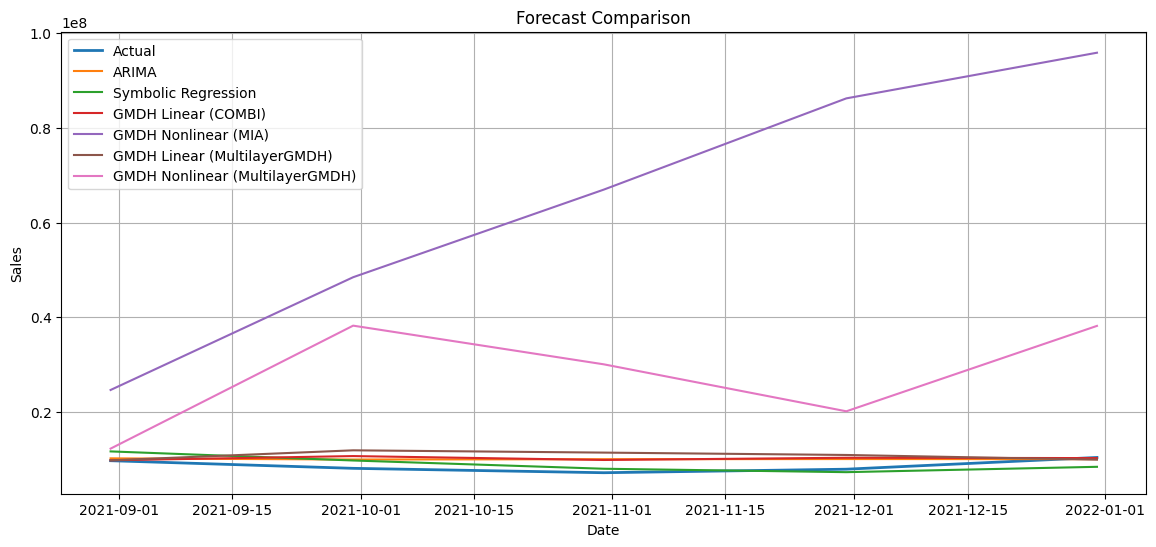

In [37]:
plt.figure(figsize=(14, 6))
plt.plot(test_dates, y_test_sr, label="Actual", linewidth=2)
plt.plot(test_dates, arima_forecast, label="ARIMA")
plt.plot(test_dates, symbolic_forecast, label="Symbolic Regression")
plt.plot(test_dates, gmdh_combi_forecast, label="GMDH Linear (COMBI)")
plt.plot(test_dates, gmdh_mia_forecast, label="GMDH Nonlinear (MIA)")
plt.plot(test_dates, gmdh_linear_forecast, label="GMDH Linear (MultilayerGMDH)")
plt.plot(test_dates, gmdh_nonlinear_forecast, label="GMDH Nonlinear (MultilayerGMDH)")
plt.title("Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
def evaluate(true, pred, name):
    print(f"{name} MAE: {mean_absolute_error(true, pred):.2f}")
    print(f"{name} RMSE: {np.sqrt(mean_squared_error(true, pred)):.2f}")
    print("-" * 30)

In [40]:
evaluate(y_test_sr, arima_forecast, "ARIMA")
evaluate(y_test_sr, symbolic_forecast, "Symbolic Regression")
evaluate(y_test_sr, gmdh_combi_forecast, "GMDH Linear (COMBI)")
evaluate(y_test_sr, gmdh_mia_forecast, "GMDH Nonlinear (MIA)")
evaluate(y_test_sr, gmdh_linear_forecast, "GMDH Linear (MultilayerGMDH)")
evaluate(y_test_sr, gmdh_nonlinear_forecast, "GMDH Nonlinear (MultilayerGMDH)")

ARIMA MAE: 1541935.89
ARIMA RMSE: 1821572.19
------------------------------
Symbolic Regression MAE: 1413256.40
Symbolic Regression RMSE: 1523932.59
------------------------------
GMDH Linear (COMBI) MAE: 1585200.34
GMDH Linear (COMBI) RMSE: 1993213.70
------------------------------
GMDH Nonlinear (MIA) MAE: 55832802.94
GMDH Nonlinear (MIA) RMSE: 61489874.74
------------------------------
GMDH Linear (MultilayerGMDH) MAE: 2322566.19
GMDH Linear (MultilayerGMDH) RMSE: 2893460.83
------------------------------
GMDH Nonlinear (MultilayerGMDH) MAE: 19137654.89
GMDH Nonlinear (MultilayerGMDH) RMSE: 21748540.86
------------------------------
